In [2]:

from occupancy.datasets.nuscenes import NuScenesDataset, NuScenesOccupancyDataset
from nuscenes.nuscenes import NuScenes
nusc = NuScenesOccupancyDataset(
    data_dir='/mnt/f/datasets/nuscenes/nuScenes-Occupancy-v0.1/', binary=False)


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

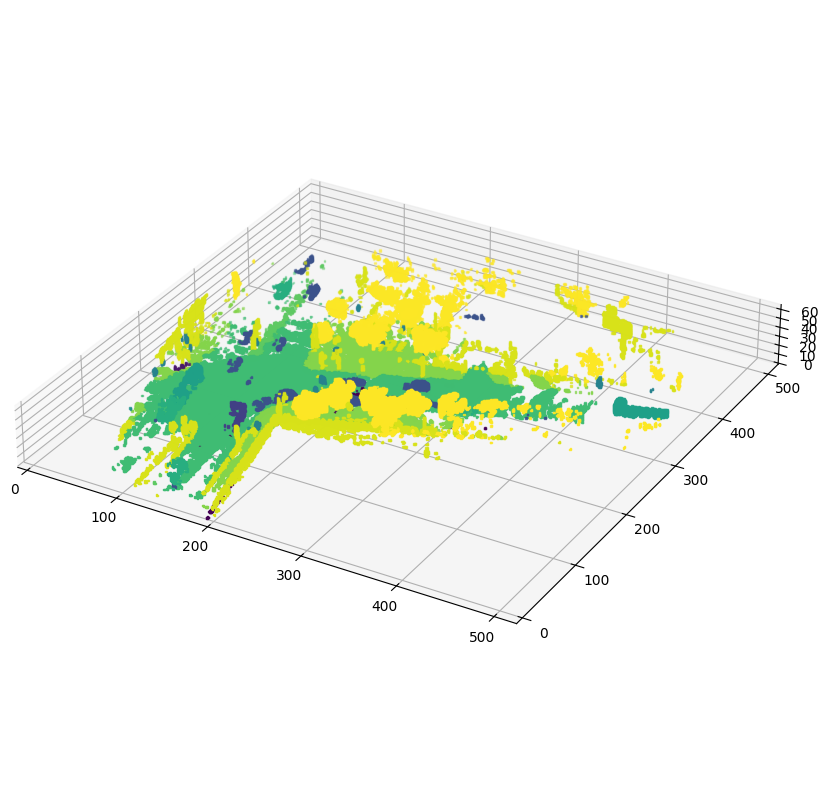

In [6]:
occ = nusc[12]
occ = F.interpolate(occ.unsqueeze(0).float(), scale_factor=2, mode='trilinear', align_corners=True).squeeze(0).argmax(0)
occ = F.one_hot(occ, num_classes=18).permute(3, 0, 1, 2).argmax(0)
i,j,k = torch.where(occ)
c = occ[i,j,k]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(i,j,k, c=c, marker='s', s=1)
ax.set_xlim(0, occ.shape[-3])
ax.set_ylim(0, occ.shape[-2])
ax.set_zlim(0, occ.shape[-1])
ax.set_box_aspect((1,1,occ.shape[-1]/occ.shape[-2]))


In [4]:
occ

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,